In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import math
%matplotlib inline

In [17]:
# Define functions

## generate_dataset: function to generate an random dataset

def generate_dataset(n_samples=100, uplift = 0):
    pre = np.random.normal(0, 1, n_samples)
    post = 10 * pre + 2 * np.sin((pre * 5) * 2 * np.pi)
    group = np.random.binomial(1,0.5,n_samples)
    df = pd.DataFrame({'pre': pre, 'post': post, 'group':group})
    df.loc[lambda df: df.group == 1, "post"] += uplift
    return df


## t_test: t-test functions on aggregated statistics


# Input parameters:

## m1, m2: the sample means for treatment and control, respectively
## s1, s2: the sample standard deviations for treatment and control, respectively
## n1, n2: the same sizes for treatment and control, respectively
## m0: the null value for the difference in means to be tested for. Default is 0
## equal.variance: whether or not to assume equal variance. Default is FALSE
## alternative: 'two-sided', 'greater', 'less'. Default is 'two-sided'

# Output values:

## A dataframe contains the following columns:
    ### treatment: sample means for treatment
    ### control: sample means for control
    ### delta: mean difference between treatment and control
    ### lift: (mu_treatment-mu_control)/mu_control
    ### tstat: t-statistic
    ### p_value: p-value from the test
    ### lower_CI: lower bound of confidence interval
    ### upper_CI: upper bound of confidence interval
    

def t_test(m1, m2, s1, s2, n1, n2, m0=0, equal_var=False, alternative = 'two-sided', alpha = 0.05):
    dat = pd.DataFrame()
    if equal_var == False:
        se = math.sqrt((s1**2/n1) + (s2**2/n2))
        # welch-satterthwaite df
        df = ((s1**2/n1 + s2**2/n2)**2)/((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    else:
        # pooled standard deviation, scaled by the sample sizes
        se = math.sqrt( (1/n1 + 1/n2) * ((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2) ) 
        df = n1+n2-2
    t = (m1-m2-m0)/se   
    if alternative == 'two-sided':
        dat = pd.DataFrame({'treatment':m1, 
                            'control':m2, 
                            'delta': m1-m2, 
                            'lift': (m1-m2)/m2, 
                            'tstat': t, 
                            'p_value': 2*scipy.stats.t.cdf(-abs(t),df), 
                            'lower_95_CI': m1-m2-scipy.stats.t.ppf(1-alpha/2,df)*se, 
                            'upper_95_CI': m1-m2+scipy.stats.t.ppf(1-alpha/2,df)*se}, index=[0])    
    elif alternative == 'greater':
        dat = pd.DataFrame({'treatment':m1, 
                            'control':m2, 
                            'delta': m1-m2, 
                            'lift': (m1-m2)/m2, 
                            'tstat': t, 
                            'p_value': 1-scipy.stats.t.cdf(t,df), 
                            'lower_95_CI': m1-m2-scipy.stats.t.ppf(1-alpha,df)*se, 
                            'upper_95_CI': float('inf')}, index=[0])  
    elif alternative == 'less':
        dat = pd.DataFrame({'treatment':m1, 
                            'control':m2, 
                            'delta': m1-m2, 
                            'lift': (m1-m2)/m2, 
                            'tstat': t, 
                            'p_value': scipy.stats.t.cdf(t,df), 
                            'lower_CI': float('-inf'), 
                            'upper_CI': m1-m2+scipy.stats.t.ppf(1-alpha,df)*se}, index=[0]) 

    return dat


## t_test_raw: t-test functions on raw data


# Input parameters:

## df: dataframe
## x: treatment
## y: control
## d: the null value for the difference in means to be tested for. Default is 0
## equal.variance: whether or not to assume equal variance. Default is FALSE
## alternative: 'two-sided', 'greater', 'less'. Default is 'two-sided'

# Output values:

## A dataframe contains the following columns:
    ### treatment: sample means for treatment
    ### control: sample means for control
    ### delta: mean difference between treatment and control
    ### lift: (mu_treatment-mu_control)/mu_control
    ### tstat: t-statistic
    ### p_value: p-value from the test
    ### lower_CI: lower bound of confidence interval
    ### upper_CI: upper bound of confidence interval
    

def t_test_raw(df,x,y, d=0, equal_var=False, alternative = 'two-sided', alpha = 0.05):
    
    print(df)

    m1,m2 = df.x.mean(),df.y.mean()
    s1,s2 = df.x.std(),df.y.std()
    n1,n2 = len(df.x),len(df.y)
    
    dat = pd.DataFrame()
    if equal_var == False:
        se = math.sqrt((s1**2/n1) + (s2**2/n2))
        # welch-satterthwaite df
        df = ((s1**2/n1 + s2**2/n2)**2)/((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    else:
        # pooled standard deviation, scaled by the sample sizes
        se = math.sqrt( (1/n1 + 1/n2) * ((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2) ) 
        df = n1+n2-2
    t = (m1-m2-d)/se   
    if alternative == 'two-sided':
        dat = pd.DataFrame({'treatment':m1, 
                            'control':m2, 
                            'delta': m1-m2, 
                            'lift': (m1-m2)/m2, 
                            'tstat': t, 
                            'p_value': 2*scipy.stats.t.cdf(-abs(t),df), 
                            'lower_95_CI': m1-m2-scipy.stats.t.ppf(1-alpha/2,df)*se, 
                            'upper_95_CI': m1-m2+scipy.stats.t.ppf(1-alpha/2,df)*se}, index=[0])    
    elif alternative == 'greater':
        dat = pd.DataFrame({'treatment':m1, 
                            'control':m2, 
                            'delta': m1-m2, 
                            'lift': (m1-m2)/m2, 
                            'tstat': t, 
                            'p_value': 1-scipy.stats.t.cdf(t,df), 
                            'lower_95_CI': m1-m2-scipy.stats.t.ppf(1-alpha,df)*se, 
                            'upper_95_CI': float('inf')}, index=[0])  
    elif alternative == 'less':
        dat = pd.DataFrame({'treatment':m1, 
                            'control':m2, 
                            'delta': m1-m2, 
                            'lift': (m1-m2)/m2, 
                            'tstat': t, 
                            'p_value': scipy.stats.t.cdf(t,df), 
                            'lower_CI': float('-inf'), 
                            'upper_CI': m1-m2+scipy.stats.t.ppf(1-alpha,df)*se}, index=[0]) 

    return dat


## CUPED: function to calculate CUPED adjusted metric

def CUPED(ds, x, y):
    theta = ds.cov().loc[x, y] / ds.cov().loc[x, x]
    
    ds['CUPED_adjusted'] = ds[y] - theta * ds[x]
    
    return ds

## Generate an random data set

In [8]:
df = generate_dataset(200, 1)

In [10]:
df

,pre,post,group
0,-0.201747,-1.127159,1
1,-0.152171,1.473640,1
2,0.329809,1.687127,0
3,-0.955509,-7.584961,0
4,0.305620,3.704910,1
...,...,...,...
195,0.472043,6.259728,0
196,1.254833,15.525321,1
197,0.559884,3.694493,0
198,-0.283200,-3.839265,0


## Distribution of the two group before adjustment

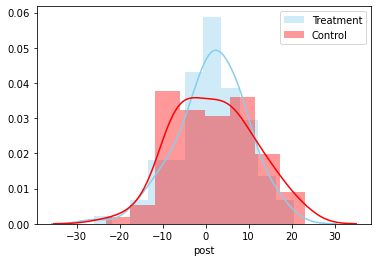

In [9]:
sns.distplot(df.loc[lambda df: df.group == 1,"post"] , color="skyblue", label="Treatment")
sns.distplot(df.loc[lambda df: df.group == 0,"post"] , color="red", label="Control")
plt.legend()

## 1. Ordinary t-test

In [14]:
m1 = df.loc[lambda df: df.group == 1,"post"].mean()
m2 = df.loc[lambda df: df.group == 0,"post"].mean()
s1 = df.loc[lambda df: df.group == 1,"post"].std()
s2 = df.loc[lambda df: df.group == 0,"post"].std()
n1 = len(df.loc[lambda df: df.group == 1,"post"])
n2 = len(df.loc[lambda df: df.group == 0,"post"])

t_test(m1, m2, s1, s2, n1, n2, m0=0, equal_var=False, alternative = 'two-sided', alpha = 0.05)

,treatment,control,delta,lift,tstat,p_value,lower_95_CI,upper_95_CI
0,1.487498,1.785221,-0.297723,-0.166771,-0.237693,0.812377,-2.768522,2.173075


P-value from ordinary two sample t-test is 0.812377, which indicates that the two group are not significantly different. 

## 2. CUPED adjusted

We simulate a pre-experiment metric "pre", which has a high correlation with the post-experiment metric "post" we are looking at. The correlation coefficient between the two metrics is 0.987 in this example.

In [15]:
correlation = df.corr().loc["pre","post"]
correlation

0.9869819085538043

We then apply the predefined CUPED function, using "pre" as the control variate, and obtain the CUPED adjusted "post" metric.

In [18]:
df_CUPED = CUPED(df, x='pre', y='post')

Run t-test again on the adjusted metric:

In [19]:
m1 = df.loc[lambda df: df.group == 1,"CUPED_adjusted"].mean()
m2 = df.loc[lambda df: df.group == 0,"CUPED_adjusted"].mean()
s1 = df.loc[lambda df: df.group == 1,"CUPED_adjusted"].std()
s2 = df.loc[lambda df: df.group == 0,"CUPED_adjusted"].std()
n1 = len(df.loc[lambda df: df.group == 1,"CUPED_adjusted"])
n2 = len(df.loc[lambda df: df.group == 0,"CUPED_adjusted"])

t_test(m1, m2, s1, s2, n1, n2, m0=0, equal_var=False, alternative = 'two-sided', alpha = 0.05)

,treatment,control,delta,lift,tstat,p_value,lower_95_CI,upper_95_CI
0,0.950207,0.36017,0.590037,1.638221,3.011513,0.002941,0.203649,0.976426


P-value from the CUPED adjusted t-test is 0.002941, which indicates that the two groups are significantly different.

## 3. Repeat the process and see the overall performance

In [33]:
def run_many_times(dataset_generator, estimator, n_runs):
    return np.array([estimator(dataset_generator(), x='pre', y='post') for _ in range(n_runs)])

def compare_estimators(dataset_generator, estimators, true_uplift, n_runs=500):
    results = {}
    
    for estimator_name, estimator in estimators.items():
        res = run_many_times(dataset_generator, estimator, n_runs)
        sns.kdeplot(res, shade=True, label=estimator_name)
        
        print("Estimator: {}".format(estimator_name))
        print("\tConfidence Interval Width: {:.3f}".format(2 * np.std(res)))
        print("\tBias: {:.3f}".format(np.mean(res - true_uplift)))
        results[estimator_name] = res
        
    ymin, ymax = plt.ylim()
    plt.vlines(uplift, 0, ymax)
    plt.vlines(0, 0, ymax, linestyles="dashed")
    plt.ylim(0, ymax)
    
    return results

def base_estimator(ds, x, y):
    a = ds[ds.group == 0]
    b = ds[ds.group == 1]
    return b[y].mean() - a[y].mean()

def cv_estimator(ds, x, y):
    theta = ds.cov().loc[x, y] / ds.cov().loc[x, x]
    
    ds_copy = ds.copy()
    ds_copy[y] = ds[y] - theta * ds[x]
    
    return base_estimator(ds_copy, x, y)

Estimator: base
	Confidence Interval Width: 1.335
	Bias: -0.013
Estimator: control variate estimator
	Confidence Interval Width: 0.178
	Bias: -0.002


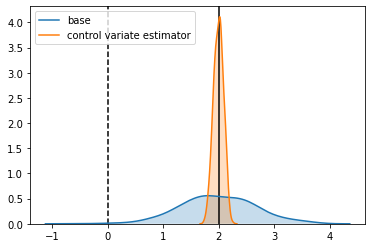

In [34]:
uplift = 2
n_samples = 1000
generator = lambda : generate_dataset(n_samples=n_samples,uplift=uplift)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator
    },
    true_uplift=uplift
)

In [35]:
from scipy.stats import norm

sample_size = 1000
alpha = 0.05
z = norm.isf(alpha / 2)
estimated_variance = df['post'].var()

detectable_effect_size = z * np.sqrt(2 * estimated_variance / sample_size)
detectable_effect_size

0.7695026353211021

In [42]:
df['post'].var()/df['CUPED_adjusted'].var()

38.659725780055126

We see a reduction in the standard deviation of the estimator. Without changing anything about our experiment, we have increased it's power. Specifically:

- We've reduced the variance by a factor of 38.66
- To get the same decrease by collecting more samples, this would take about 38.66 times more samples

